# 0.0 IMPORTS

In [84]:
import math
import inflection
import datetime

import numpy   as np
import pandas  as pd
import seaborn as sns

from scipy                import stats
from tabulate             import tabulate
from IPython.core.display import HTML
from IPython.display      import Image
from matplotlib           import pyplot as plt

## 0.1 Helper Functions

In [2]:
def cramer_v (x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    
    r , k = cm.shape 
    
    chi2 = stats.chi2_contingency (cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    
    return v

def jupyter_settings():
    %matplotlib inline
    %pylab inline


    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 16]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 15
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False) #low_memory argumento que avisa para o computador ler o arquivo todo de uma vez, se for true, vai considerar q o pc tem pouca                                                                       memória e ler pedaço por pedaço 
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge 

df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store') #how = forma que você quer que seja concatenado os datasets (neste caso a coluna Store vai pra esquerda)
                                                                       #on = coluna que existe em comum nos datasets e será referencia na concatenação 

# 1.0 Passo 01 - DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy() #para evitar caso realize mudanças no dataset para não precisar rodar tudo de novo 

In [5]:
df1.columns 

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment','CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x) # função que realizar o metodo para descrever dados

cols_new = list(map(snakecase, cols_old)) #função para aplicar uma função em todos os dados da lista mencionada

#rename 
df1.columns = cols_new #renomeando a coluna do dataset com as modificações 

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}') #determinação das estruturas do tamanho do dataset
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1.dtypes #determinação dos tipos das variaveis 

store                            int64
day_of_week                      int64
date                            object
sales                            int64
customers                        int64
                                ...   
competition_open_since_year    float64
promo2                           int64
promo2_since_week              float64
promo2_since_year              float64
promo_interval                  object
Length: 18, dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [10]:
df1.isna().sum() #função para ver os dados faltantes aplicados em conjuntos c a função para somar a quantidade de dados faltantes
                 #três formas de tratar o NA: 
                 #1 - Exclui o NA = Muito mais rapido porem perde muita informação 
                 #2 - Algoritimos de machine learning que façam a substituição baseada no comportamento da coluna
                 #3 - Pensando no negócio (entendo a variavel)

store                               0
day_of_week                         0
date                                0
sales                               0
customers                           0
                                ...  
competition_open_since_year    323348
promo2                              0
promo2_since_week              508031
promo2_since_year              508031
promo_interval                 508031
Length: 18, dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
# jogamos um valor acima da maior distancia pois, não temos uma loja competitiva ou está muito longe

#Consideramos as datas de inicio de competição e de inicio de promoção como a mesma data da ultima venda, pois, quando formos fazer a subtração de datas, chegaremos em zero, levando a conclusão de que não tem competições ou promoções. 

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#Consideramos que o mes da compra é o mesmo mes para os resultados NA nesta coluna, caso contrario, retorna o mes que já é existente


#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#Consideramos que o ano da compra é o mesmo ano para os resultados NA nesta coluna, caso contrario, retorna o ano que já é existente

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#Consideramos que a semana da compra é o mesmo semana para os resultados NA nesta coluna, caso contrario, retorna a semana que já é existente

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#Consideramos que o ano da compra é o mesmo ano para os resultados NA nesta coluna, caso contrario, retorna o ano que já é existente

#promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# dicionario criado para comparar com a coluna date, para retornar o mes, relatado na data da compra. 

df1['promo_interval'].fillna(0, inplace = True)
#transformou tudo que é NA em zero 

df1['month_map'] = df1['date'].dt.month.map(month_map) 
#coluna que retornar os meses descritos no dicionario baseado na data da compra

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)
#coluna criada para nos retornar com 1 se a data de compra foi realizada dentro do periodo de promoção e 0 para a que não foi comprada no periodo de promoção. 

In [13]:
df1.isna().sum()

store                0
day_of_week          0
date                 0
sales                0
customers            0
                    ..
promo2_since_week    0
promo2_since_year    0
promo_interval       0
month_map            0
is_promo             0
Length: 20, dtype: int64

## 1.6 Change types

In [14]:
df1.dtypes #conferindo novamente nossos dados 

store                         int64
day_of_week                   int64
date                 datetime64[ns]
sales                         int64
customers                     int64
                          ...      
promo2_since_week           float64
promo2_since_year           float64
promo_interval               object
month_map                    object
is_promo                      int64
Length: 20, dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) #Função que determina a coluna como inteira
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical 

In [21]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']) #função para selecionar as colunas pelo tipe delas
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]']) 

In [22]:
num_attributes.sample(2) #função que seleciona linhas aleatórias

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
643577,1008,1,9332,1054,1,1,0,30.0,9,2010,0,49,2013,0
19647,693,2,9218,616,1,1,0,450.0,7,2015,1,40,2011,1


In [23]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
531966,0,c,c,"Feb,May,Aug,Nov",Mar
541878,0,a,c,0,Mar


## 1.7.1 Numerical Attributes

In [24]:
#APROFUNDAR MAIS DEPOIS NAS ANALISES DE SKEWNESS E KURTOSIS

# Central Tendency - Mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T #apply função para aplicar em todas as colunas uma operação
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T
                   
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range', 'mean','median','std','skew','kurtosis']

In [25]:
m #APROFUNDAR MAIS NO APRENDIZADO DE ANALISE DESCRITIVA DAS METRICAS ESTATISTICAS DOS DADOS

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/diego/.pyenv/versions/3.10.1/envs/DsemProducao/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

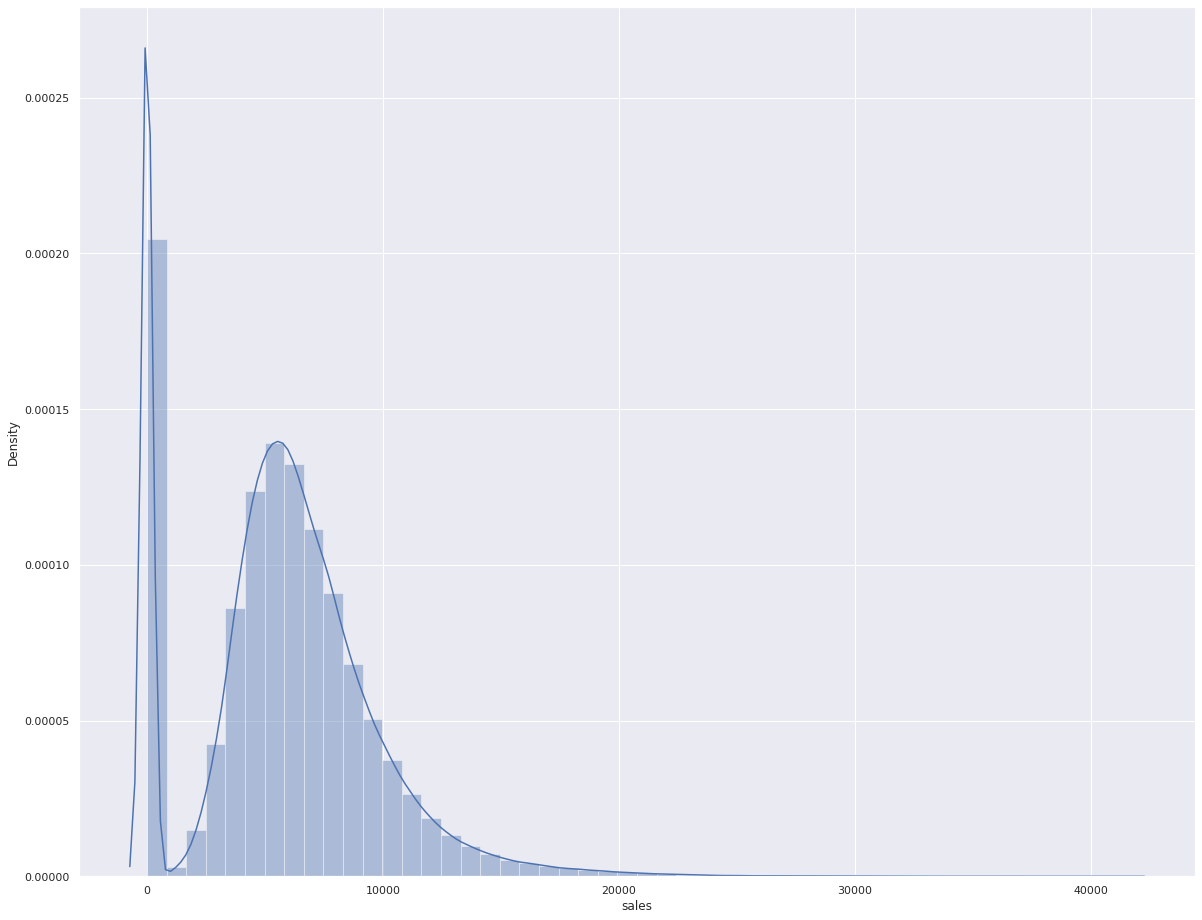

In [26]:
plt.figure(figsize=(20, 16)) #tamanho dos graficos plotados
sns.distplot (df1['sales']) #função para plotar grafico com a distribuição dos preços 

#APROFUNDAR MAIS NAS ANALISES DA DISTRIBUIÇÃO DE VENDAS

## 1.7.2 Categorical Attributes

In [27]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

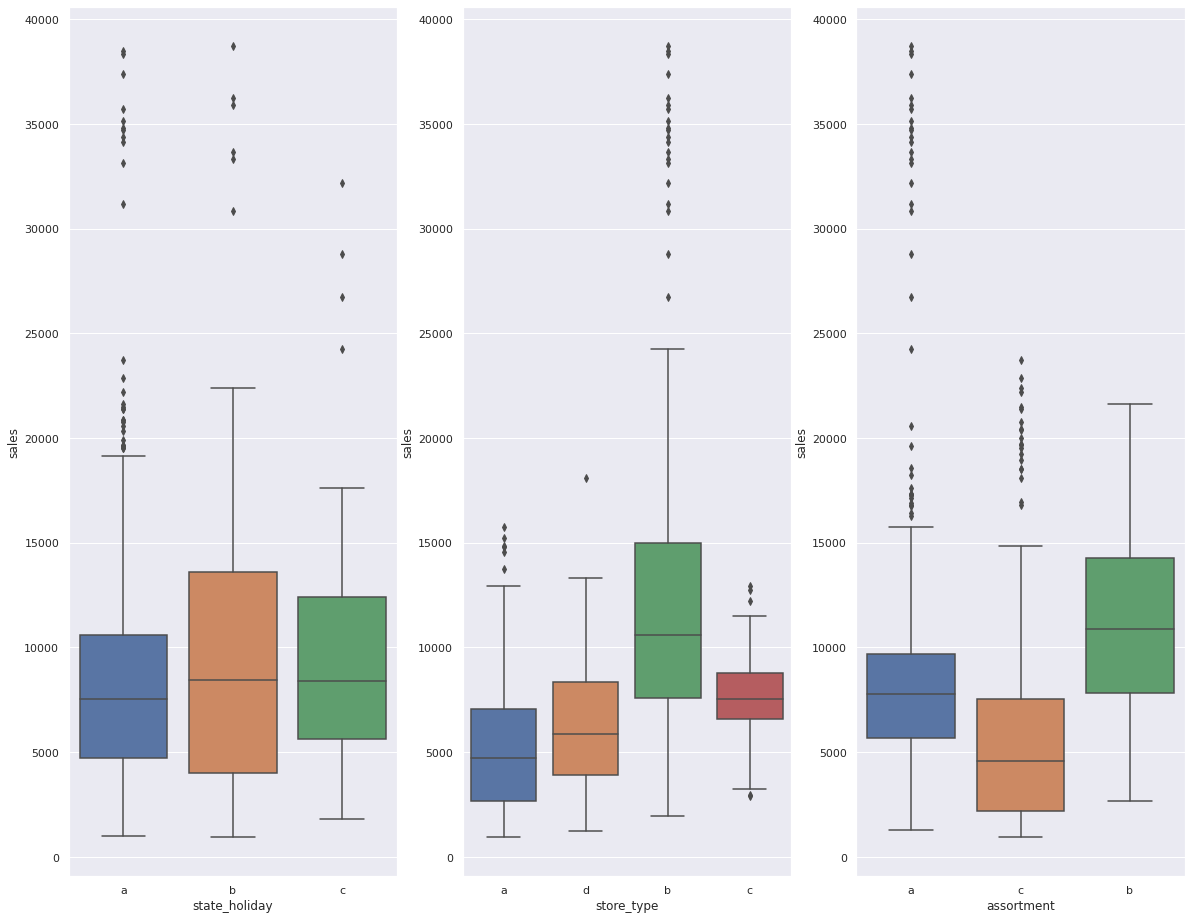

In [36]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20, 16))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

#linha do meio é o Q50 ou mediana
#linha de baixo é a Q25, o intervalo é o volume de vendas do Q25 até Q50
#linha de cima é o Q75, o intervalo é o volume de vendas do Q50 até Q75
#os valores fora desse intervalo são considerados outliers 
#linha de baixo é o Q1-1.5* (Q3-Q1)
#linha de cima é o Q3+1.5 *(Q3-Q1)

#No feriado do estado , o feriado B tem uma mediana maior que a do A e parecido com o C, só que tem um equilibrio entre as diferenças de quartil, no c temos diferença no intervalo

#APROFUNDAR MAIS NO COMPORTAMENTO DE VARIAVEIS CATEGORICAS

# 2.0 Passo 02 - FEATURE ENGINEERING

In [37]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

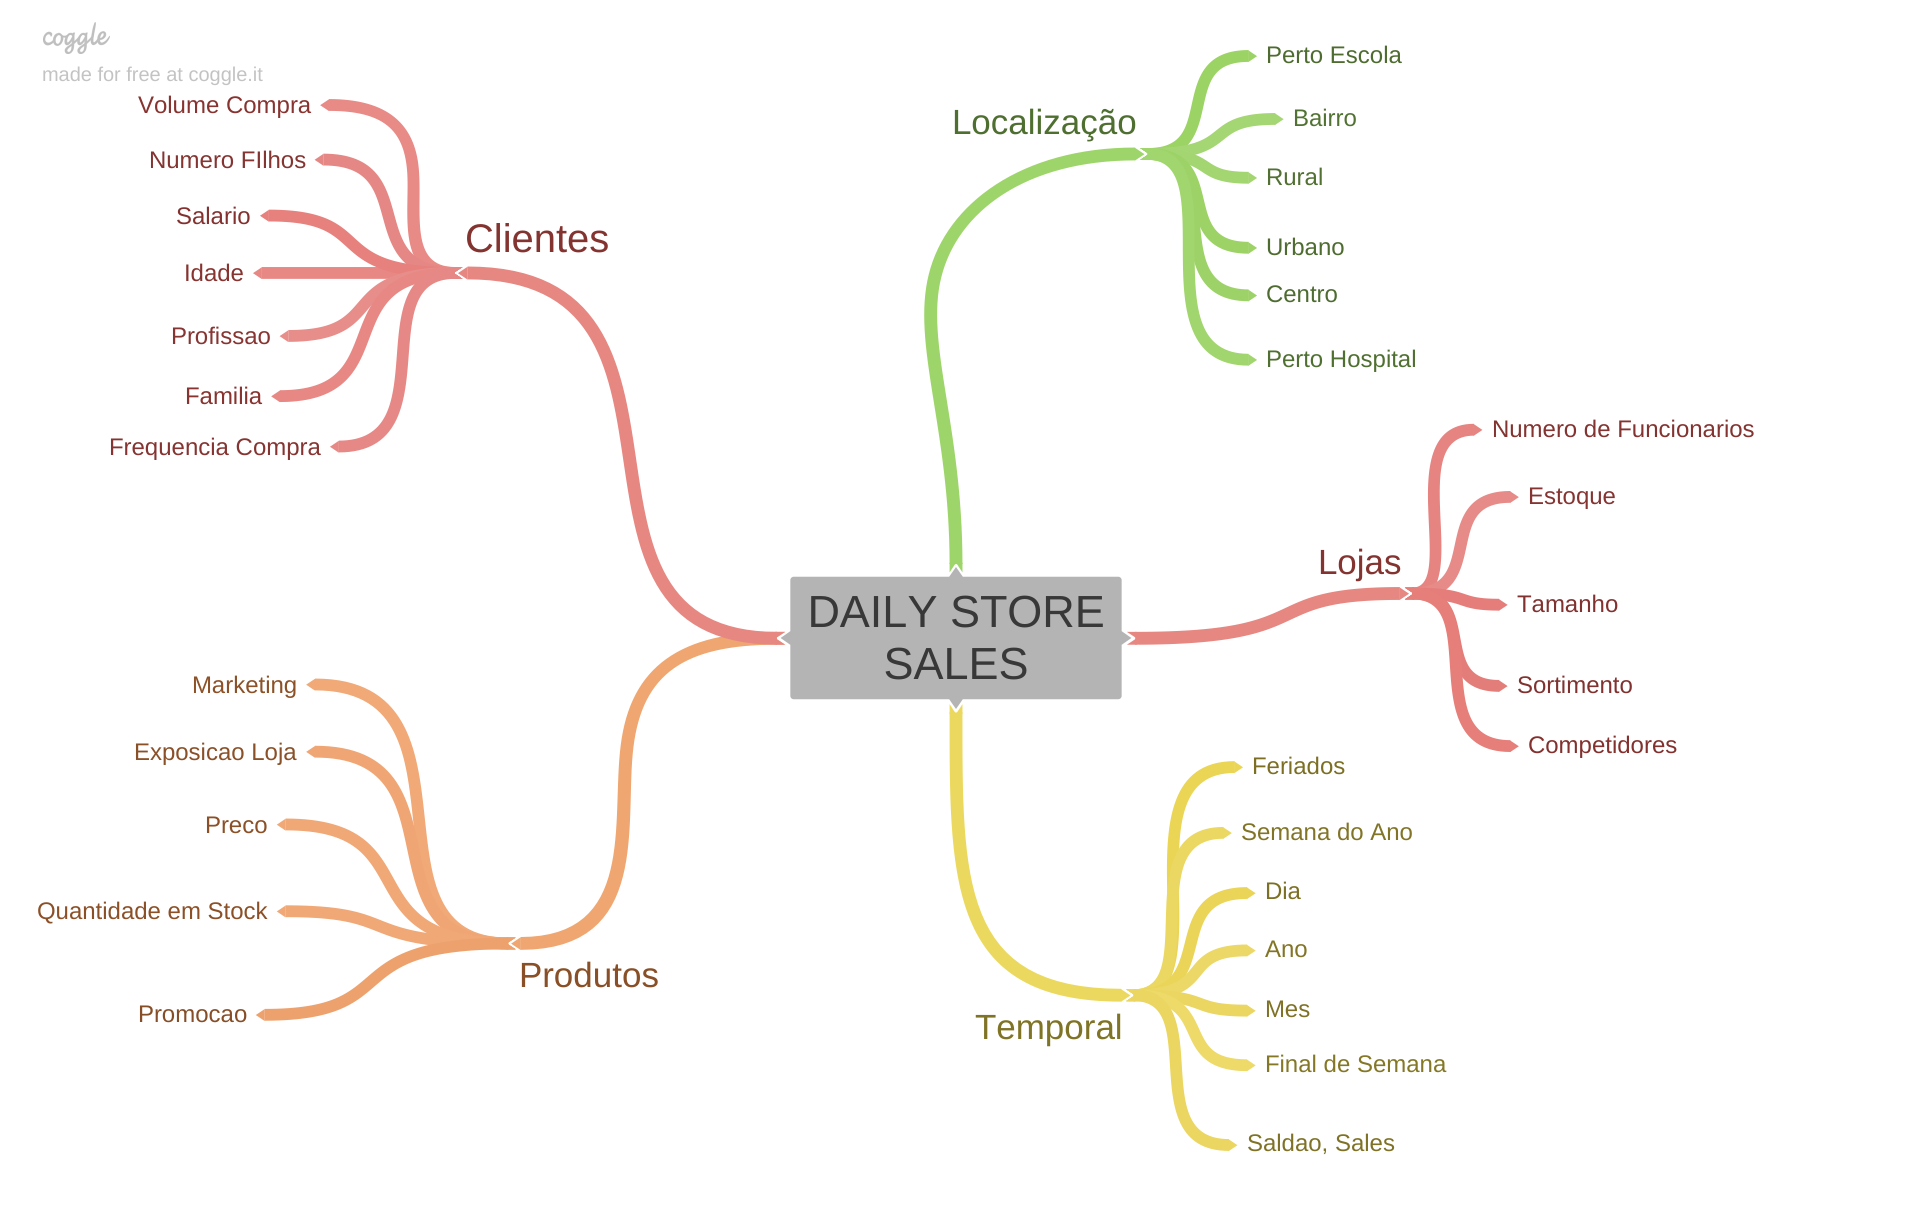

In [38]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3**. Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses Produtos

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [39]:
#year
df2['year'] = df2['date'].dt.year #função para extrair somente o ano da data

#month
df2['month'] = df2['date'].dt.month #função para extrair somente o mês da data

#day
df2['day'] = df2['date'].dt.day #função para extrair somente o dia da data

#week of year
df2['week_of_week'] = df2['date'].dt.weekofyear #função que retorna o número da semana da data

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') #função que retorna uma string do objeto da data

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 ) # função para pegar dados de uma data em diferentes colunas 
df2['competition_time_month'] = ((df2['date']-df2['competition_since'] )/30).apply( lambda x: x.days).astype(int) #função que extrai os dias da diferença entre duas datas

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) #transformação da data em string para realizar o join entre elas, separadas por um traço

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w')-datetime.timedelta(days=7)) #formatar a data para saber o inicio da promoçao 

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int) #quantidade de semanas que a promoção ficou ativa

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') # substituição das letras da coluna assortment pela palavra que representa

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) # substituição das letras da coluna state holiday pela palavra que representa

#APROFUNDAR MAIS NA MANIPULAÇÃO DE DATAS

/tmp/ipykernel_3832/431801423.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_week'] = df2['date'].dt.weekofyear #função que retorna o número da semana da data


In [40]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
...,...,...,...,...,...
year_week,2015-30,2015-30,2015-30,2015-30,2015-30
competition_since,2008-09-01 00:00:00,2007-11-01 00:00:00,2006-12-01 00:00:00,2009-09-01 00:00:00,2015-04-01 00:00:00
competition_time_month,84,94,105,71,4
promo_since,2015-07-27 00:00:00,2010-03-22 00:00:00,2011-03-28 00:00:00,2015-07-27 00:00:00,2015-07-27 00:00:00


# 3.0 Passo 03 - FILTRAGEM DE VARIÁVEIS 

In [41]:
df3 = df2.copy()

In [42]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [43]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [44]:
cols_drop = ['customers', 'open', 'promo_interval','month_map']  # Não terei a previsão de pessoas daqui 6 semanas 
                                                                 # Não interessa mais a informação 'open' pois já filtramos as vezes que está aberta
                                                                 # colunas auxiliares 
df3 = df3.drop (cols_drop, axis = 1)

In [45]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS (EDA)

In [46]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

/home/diego/.pyenv/versions/3.10.1/envs/DsemProducao/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

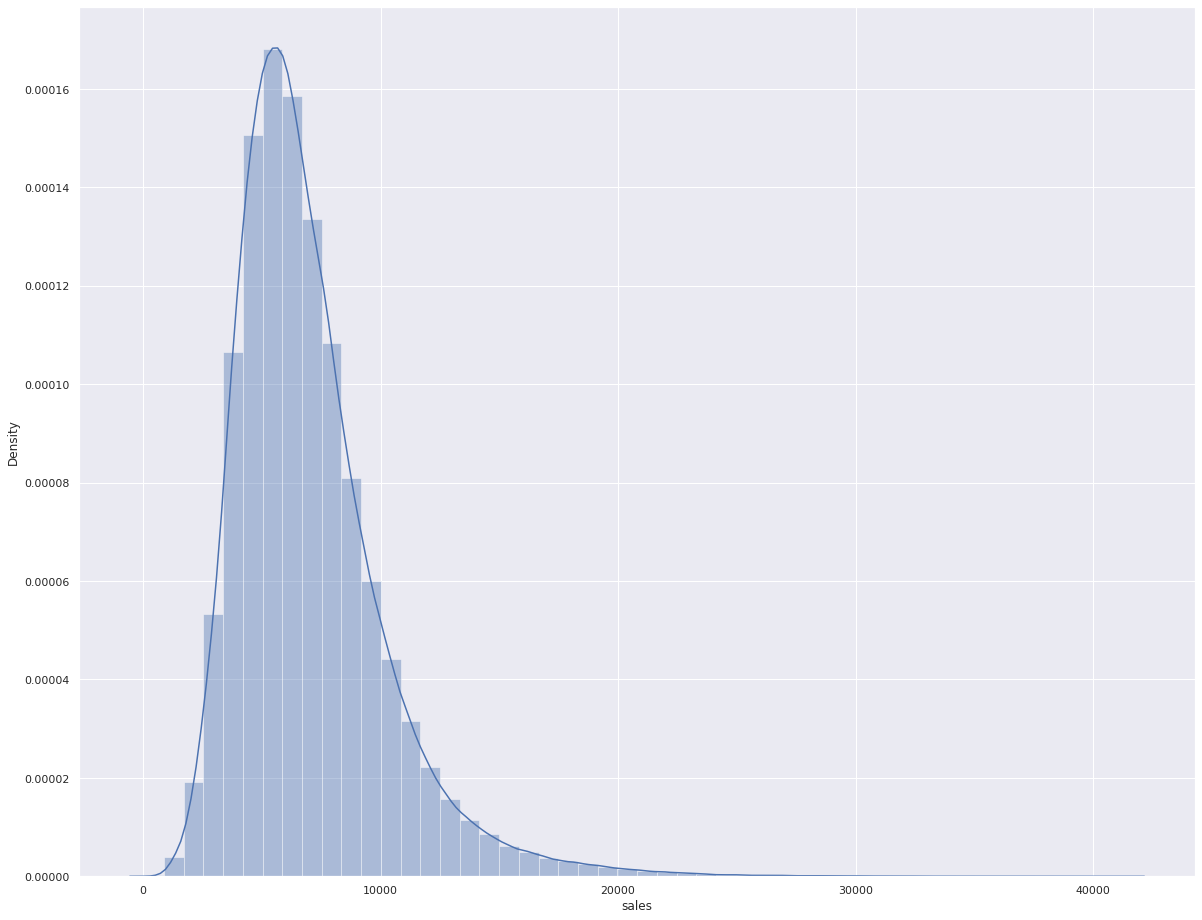

In [47]:
sns.distplot(df4['sales']) #distribuição das vendas #sales = variavel resposta
                           #Formato de sino, tem kurtosis, skew mais para esquerda = positiva, mas não ta centrada, próxima da normal 
                           #Condição esperadas: dados independentes e normalmente distruibuidos, que eles sigam uma distribuição normal, quanto mais normal for a variavel resposta, melhor vai ser                             perfomado, existem muitas tecnicas pra isso, como a log, boxpot, etc, depende do conhecimento do negócio 
                           #kde = False, tira a linha e mantem só o histrograma 

### 4.1.2 Numerical Variable

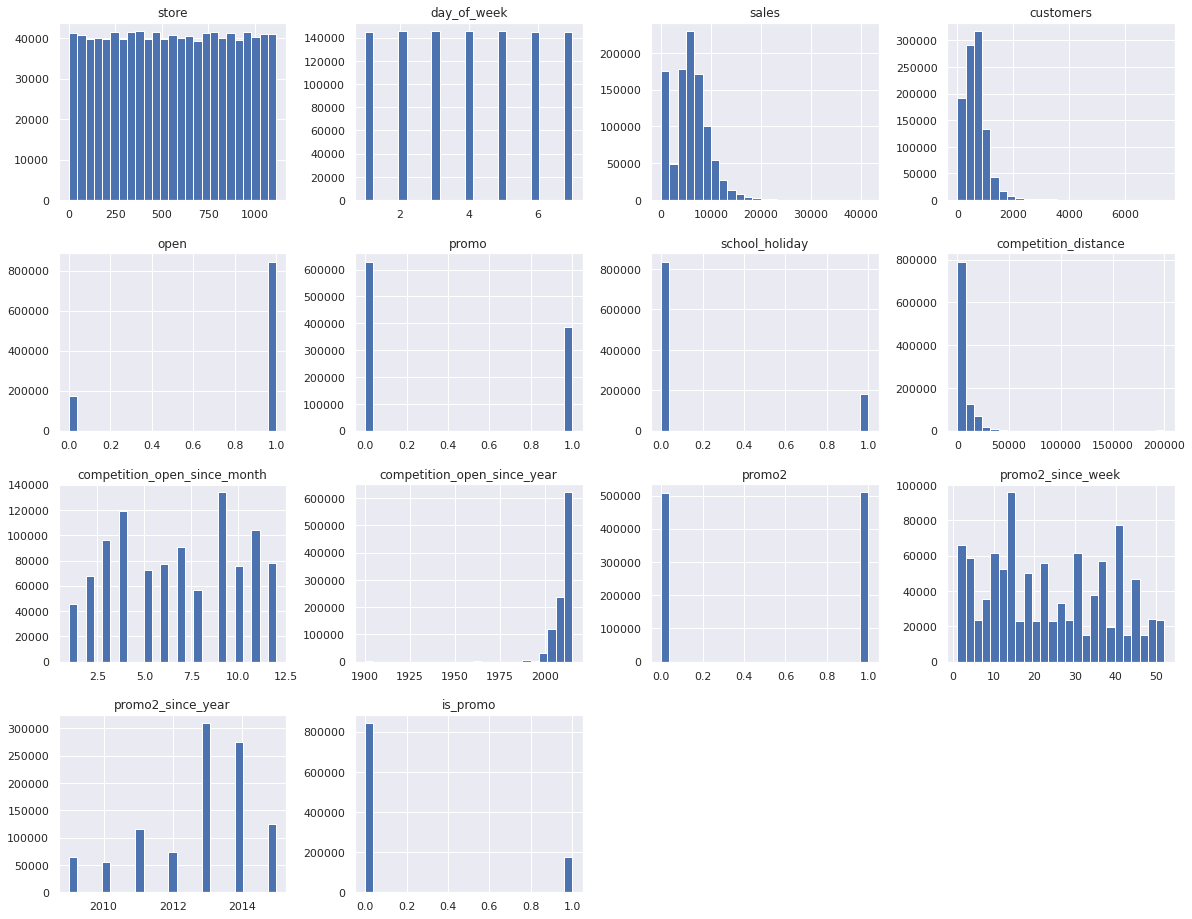

In [48]:
num_attributes.hist( bins = 25); # ' ; ' retira as escritas
                                 # cada retangulo pra demonstrar o conjunto de dados

In [49]:
# competition_distance = As vendas são muito maiores quando não tem competidores por perto, e quando tem, aumentam se a distancia aumentar. 

#competition_open_since_month = Não existe um padrão para determinar o que acontece com a vendas quando os competidores abrem suas lojas em um mes ou outro.

#competition_open_since_year = As vendas aumentaram muito com o passar dos anos com a abertura de competidores

# customers = As vendas parecem diminuir com o aumento de pessoas

# day_of_week = As vendas poucam mudam de acordo com o dia da semana

# is_promo = As vendas diminuem quando tem promoção 

# open = Obviamente as vendas são maiores quando estão abertas

# promo = comportamento igual ao da coluna is_promo

# promo2 = Não existe muita diferença com promo ou não 

# primo2_since_week = não existe um padrão de vendas para a quantidade de semanas em promo2

# promo2_since_year = Em 2013 temos um pico muito grande de vendas, dps houve decaimento

# sales = As vendas se concentram mais ou menos em 500 mil

# school_holiday = as vendas são maiores quando não tem feriado escolar 

# store = Não a uma variancia de comportamento 

### 4.1.3 Categorical Variable 

In [50]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [53]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [54]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/home/diego/.pyenv/versions/3.10.1/envs/DsemProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/diego/.pyenv/versions/3.10.1/envs/DsemProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/diego/.pyenv/versions/3.10.1/envs/DsemProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

<AxesSubplot:xlabel='sales', ylabel='Density'>

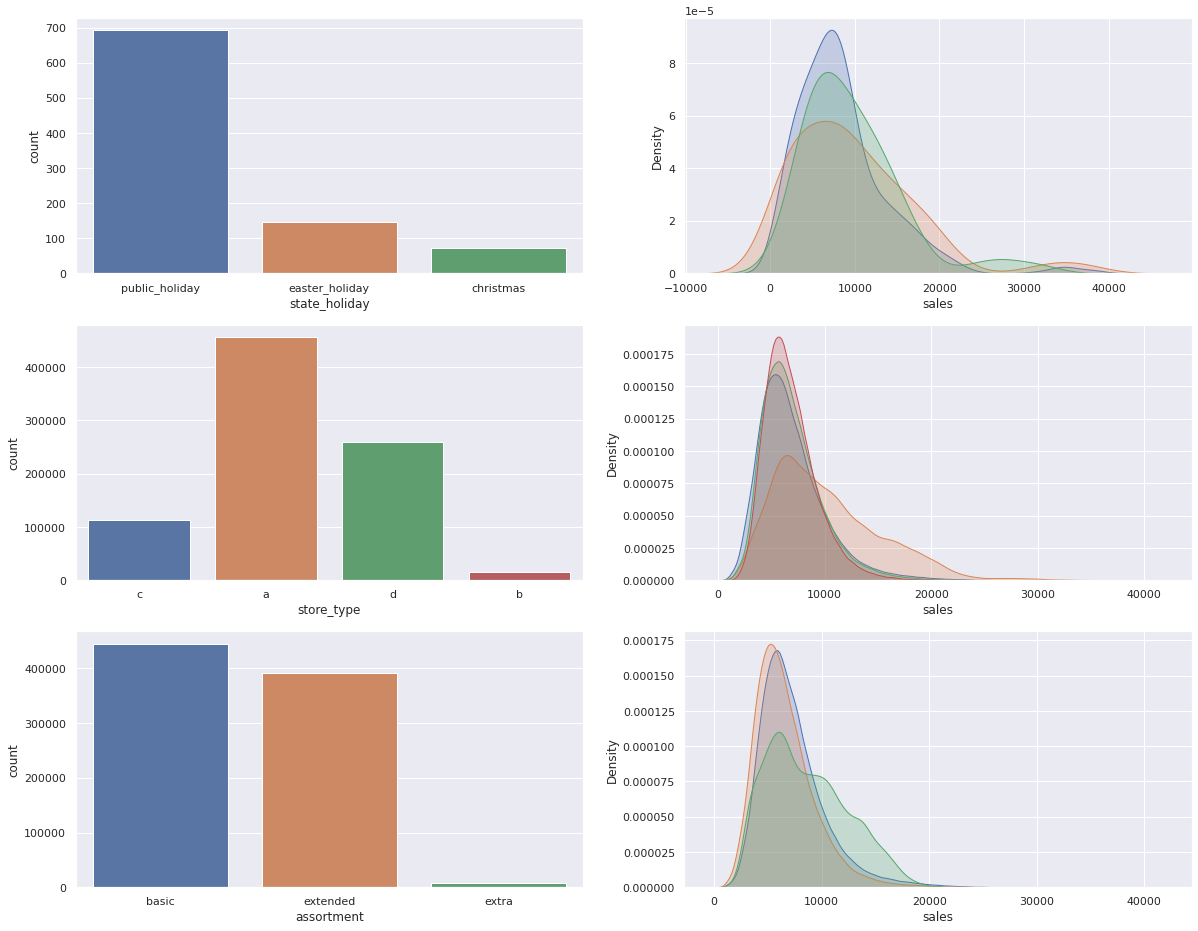

In [55]:
#APROFUNDAR NAS ANALISES APROFUNDADAS DO COMPORTAMENTO DAS VARIAVEIS CATEGORICAS

#state holiday 
plt.subplot(3,2,1) #ajuste de gride
a = df4[df4['state_holiday'] != 'regular_day'] # para vermos a distribuição dos feriados
sns.countplot(a['state_holiday'])              # vemos de forma expressiva apenas os dias regulares, pois temos muito mais dias regulares no ano que feriados (por isso foi selecionado diferente                                                    de regular day)
                                               # função da biblioteca que plota um grafico com a contagem de cada variavel 
                                               # label = nome da coluna , shade= deixar sombreado
plt.subplot(3,2,2) #ajuste de gride
sns.kdeplot (df4[df4['state_holiday']  == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday']  == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday']  == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3) #ajuste de gride
sns.countplot(df4['store_type'])    

plt.subplot(3,2,4) #ajuste de gride
sns.kdeplot (df4[df4['store_type']  == 'a']['sales'], label='a', shade=True)
sns.kdeplot (df4[df4['store_type']  == 'b']['sales'], label='b', shade=True)
sns.kdeplot (df4[df4['store_type']  == 'c']['sales'], label='c', shade=True)
sns.kdeplot (df4[df4['store_type']  == 'd']['sales'], label='d', shade=True)

#assortment 
plt.subplot(3,2,5) #ajuste de gride
sns.countplot(df4['assortment'])    

plt.subplot(3,2,6) #ajuste de gride
sns.kdeplot (df4[df4['assortment']  == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot (df4[df4['assortment']  == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot (df4[df4['assortment']  == 'extra']['sales'], label='extra', shade=True)

## 4.2 Analise Bivariada

In [ ]:
#APROFUNDAR NAS ANALISES EXPLORATORIAS 

In [43]:
#realizamos os testes de hipoteses por 3 motivos.
#1. Ganhar experiência de Negócio
#2. Para validar as hipoteses
#3. Para gerar o promeiro insights se as variaveis tem relevancia pro modelo ou não .

### H1. Lojas com maior sortimentos deveriam vender mais

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

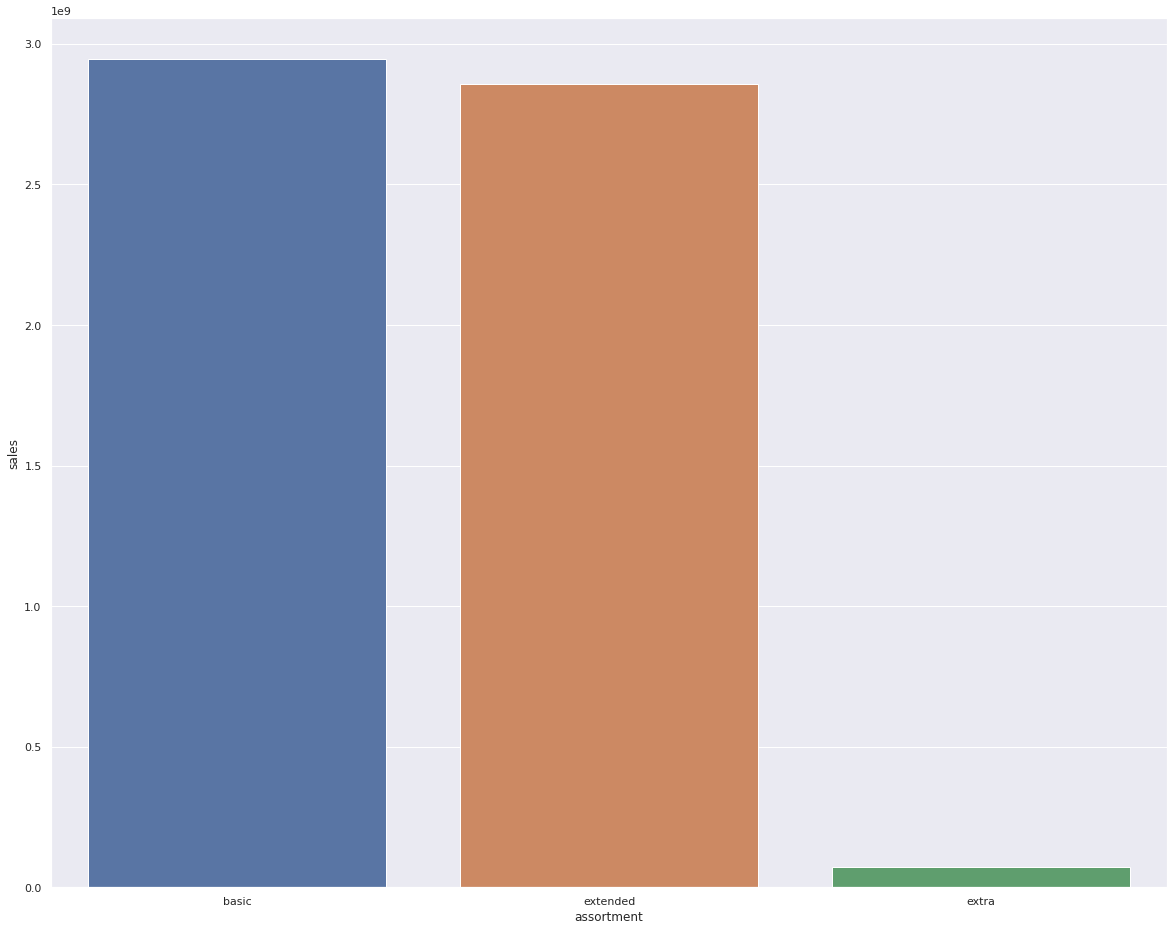

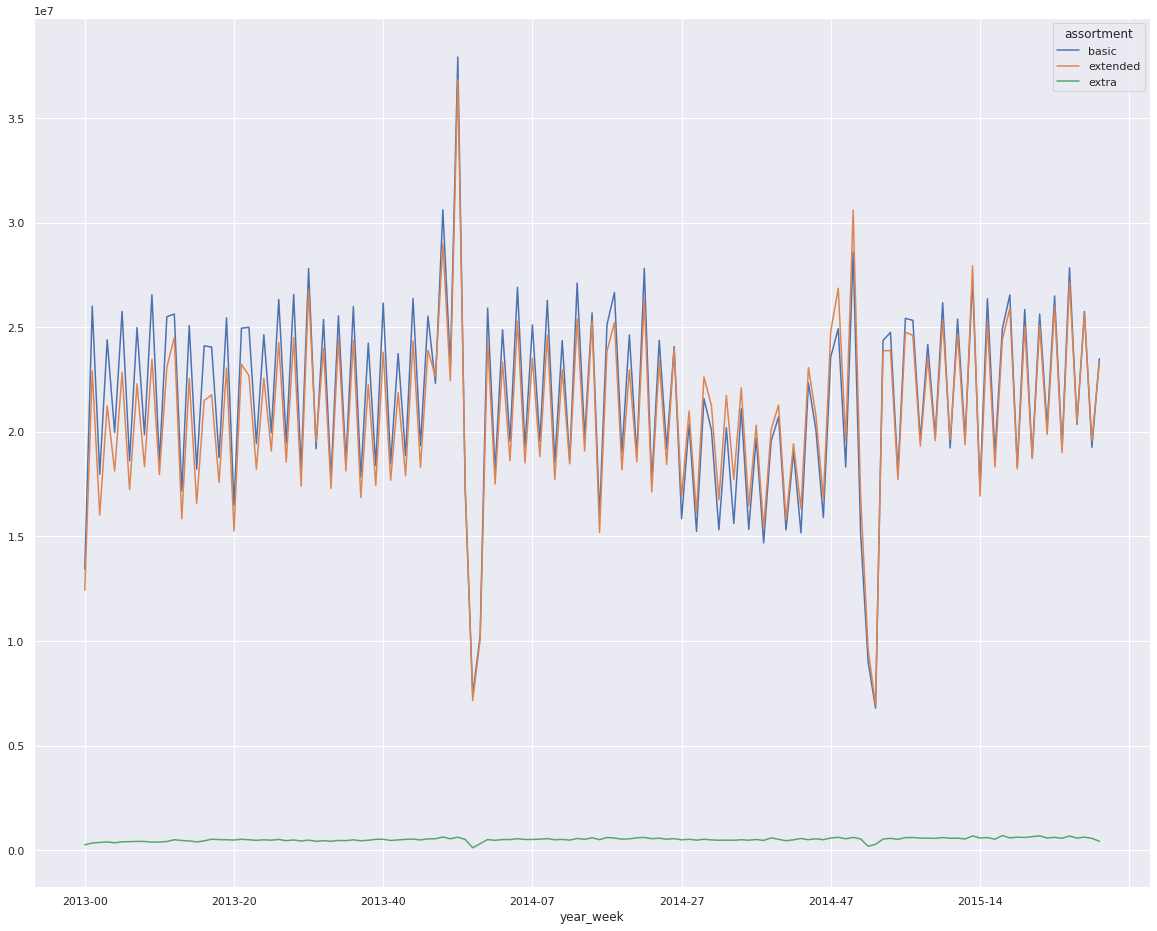

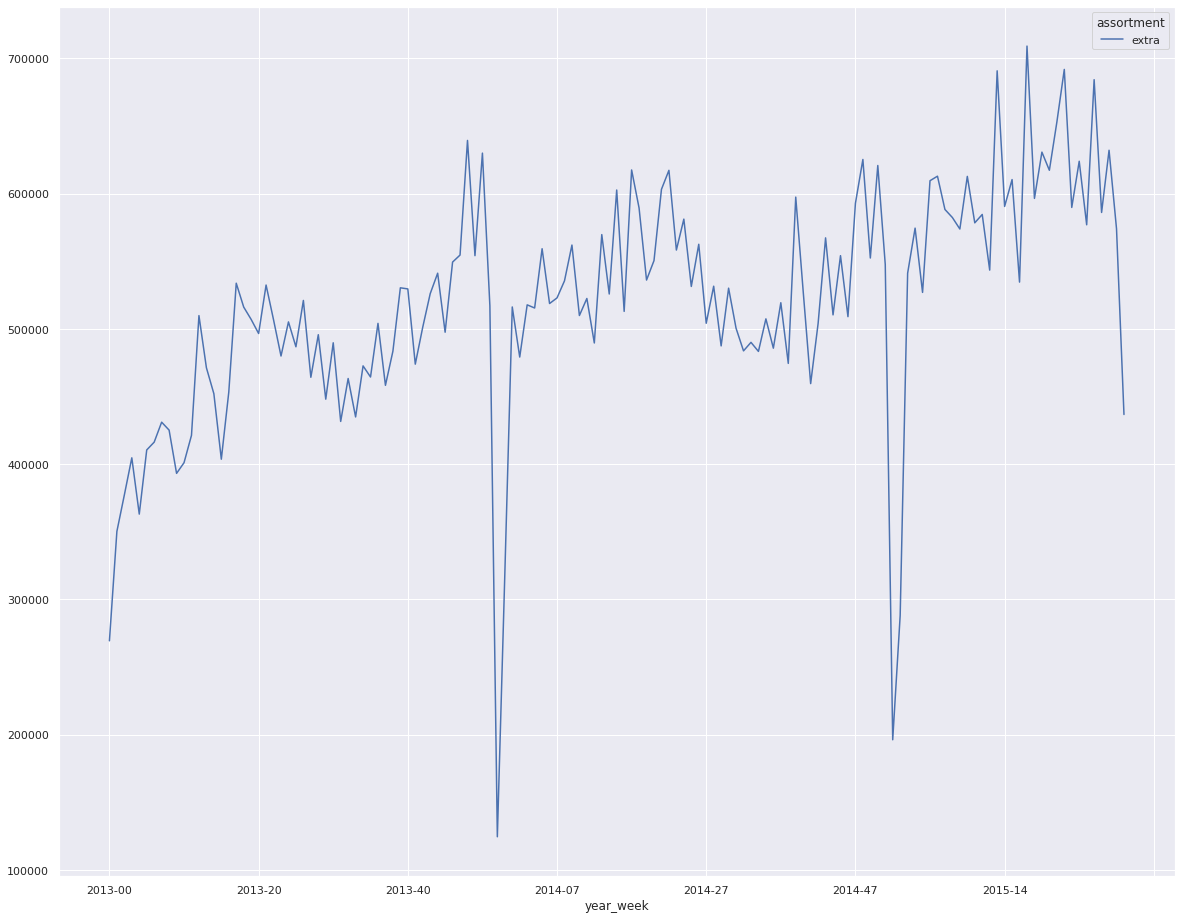

In [56]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index() #segregamos as vendas por tipo de assortment, observamos que a hipotese não era verdeira, pois as vendas com                                                                                        assortment extra são muito menores
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby (['year_week', 'assortment']).sum().reset_index() #devido as vendas serem muito baixas para o tipo extra, consideramos que talvez isso não                                                                                                             tenha sempre sido assim, que pode ter tido vendas maiores anteriormente
aux2.pivot(index = 'year_week', columns ='assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra'] # ao observamos que com o passar das semanas no ano, as vendas ainda são baixas, obsevamos também comportamentos que nao dava pra ver no segundo grafico 
aux3.pivot(index = 'year_week', columns ='assortment', values = 'sales').plot()

#conclusao, vende menos, hipotese errada. Lojas com maior sortemento vendem menos
#variavel importante pois, quando formos treinar nosso algoritimo, trabalhara de forma parecida com os outros dois assertments e o extra com valores menores e maiores variações

### H2. Lojas com competidores mais próximos deveriam vender menos

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

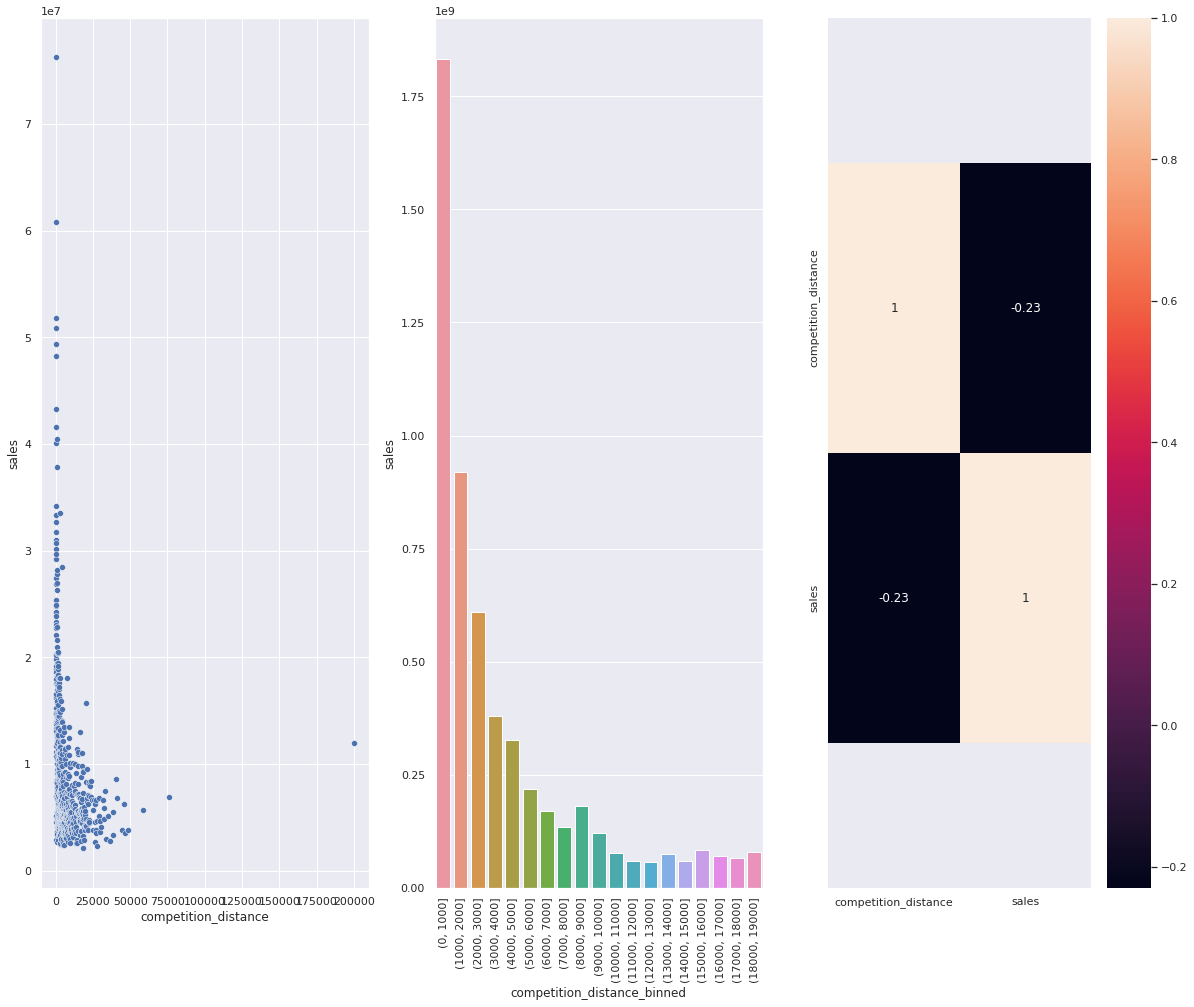

In [57]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 ); #outra forma de ver o grafico quando tiver ruim de ver

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) ) #aumentando }
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 ); #rotacionar a legenda pra ver melhor

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 ); #mais proxima de 0, mais fraca correlação, mais próximo de 1, mais forte. Indicando que quanto mais proximo do concorrente, maior a venda!

# As vendas são maiores com a distancia menor. Insgths chocante, provavelmente pq isso gera um centro economico, empresas fornecendo o mesmo produto, tras mais clientes. 

### H3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

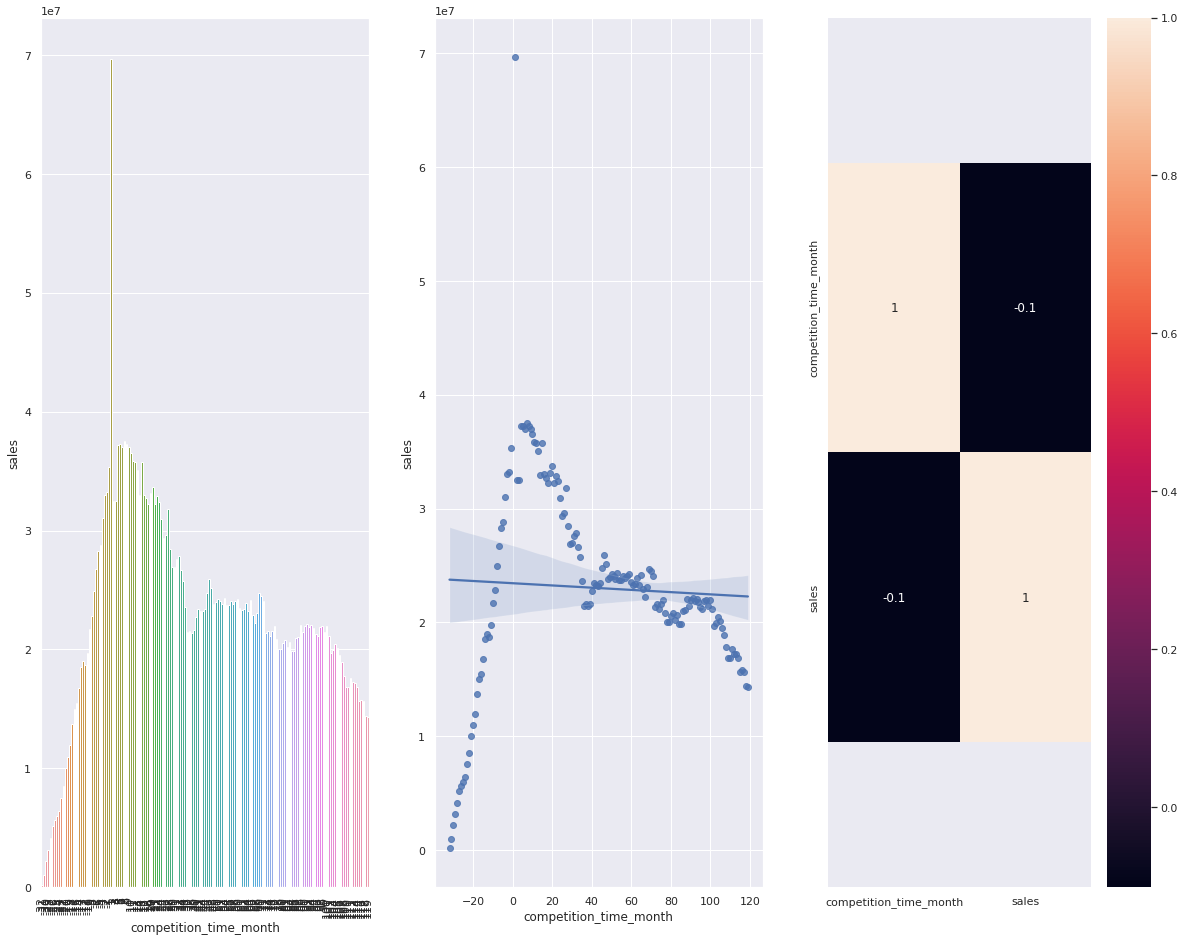

In [58]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index() #queremos ver as vendas por tempo de competição (mes)
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )] #ruim de visualizar, então filtramos até os 120 primeiros dias e que começaram ao mesmo tempo
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90 ); #girar a legenda

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True ); #Para sabermos a força da variavel 
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

#correlação não tão proxima de zero, hipotese será utilizada

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

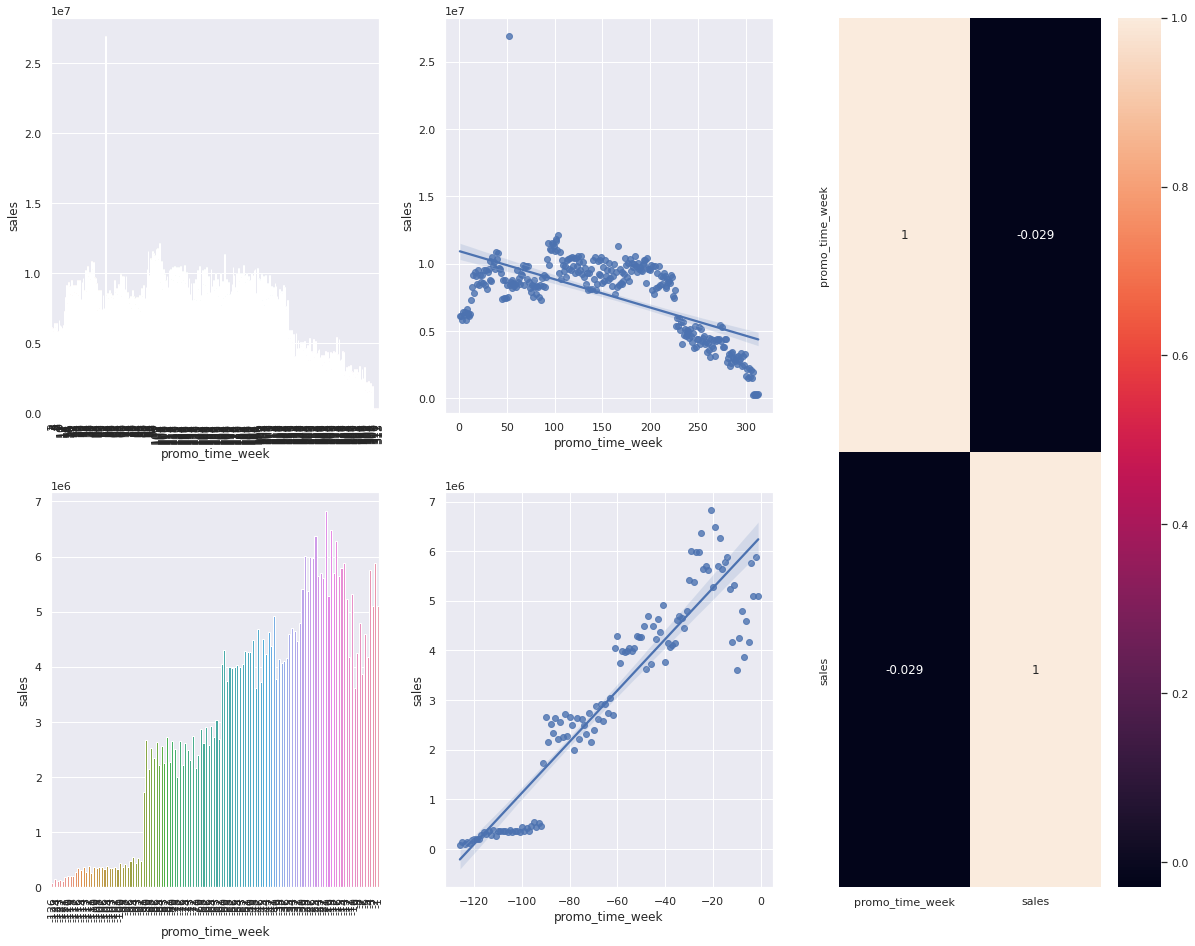

In [59]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()#todas que a promoção já aconteceu ou ainda vai acontecer (numeros positivos e negativos)
#sns.barplot (x='promo_time_week', y='sales', data=aux1); #Muito ruim pra visualizar, dividimos em dois periodos, os que foram vendidos na promoção normal e na promoção extendida
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )

sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )

aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )

sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] ) #para ver a tendencia do grafico, queriamos descobrir se a tendencia é diminuir as vendas e confirmamos ela

sns.heatmap( aux1.corr( method='pearson' ), annot=True ); # determina a força da variavel, para sabermos se é uma variavel boa ou não 

#A hipotese é falsa, pois ela vende regularmente na promoção extendida, depois decai 

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>

In [48]:
#hipotese similar, deveriamos criar nova coluna por dia, vamos realizar no proximo ciclo CRISP 

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [60]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


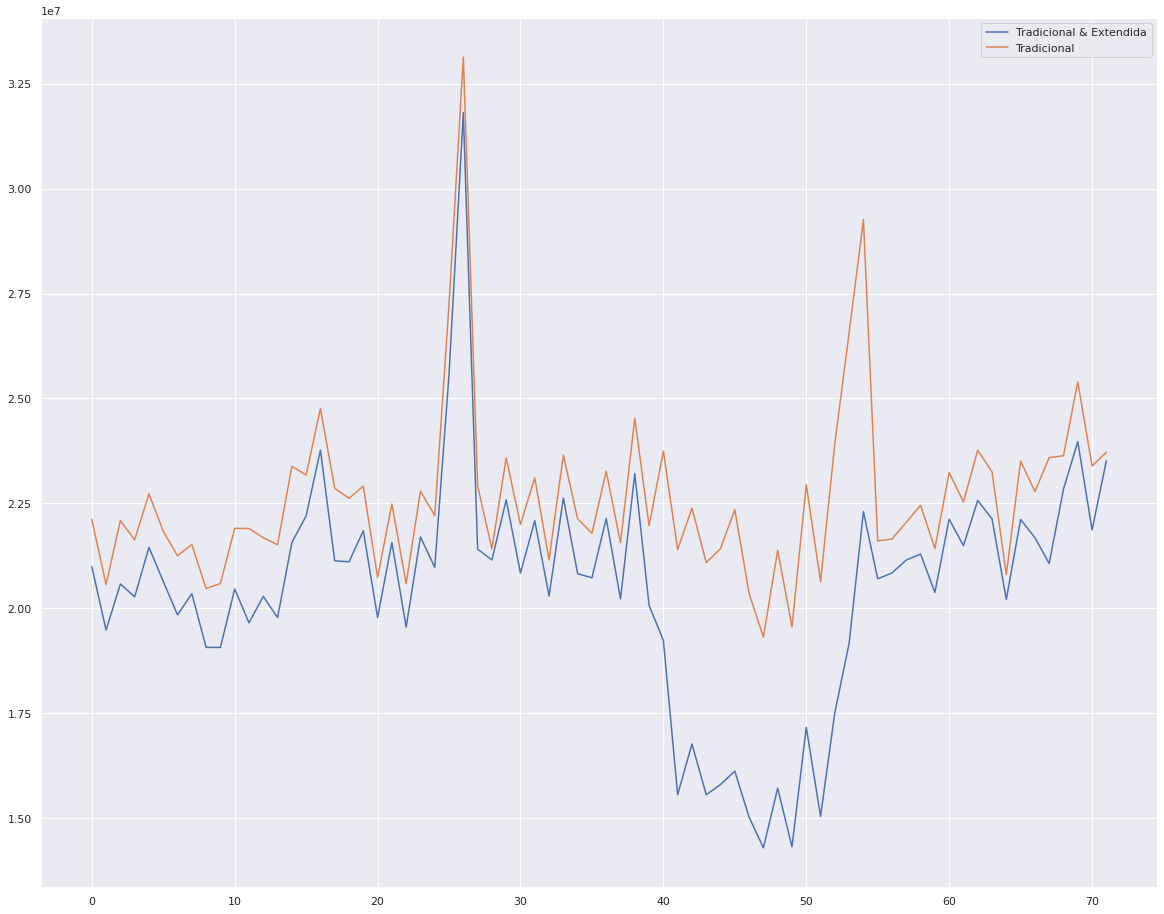

In [61]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index() #queriamos saber se durante o passar do tempo, houve outro                                                                                                                                           comportamento das promoções
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index() #variaveis aparesentam o mesmo comportamente, provavelemnte não serão                                                                                                                               variaveis importantes
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

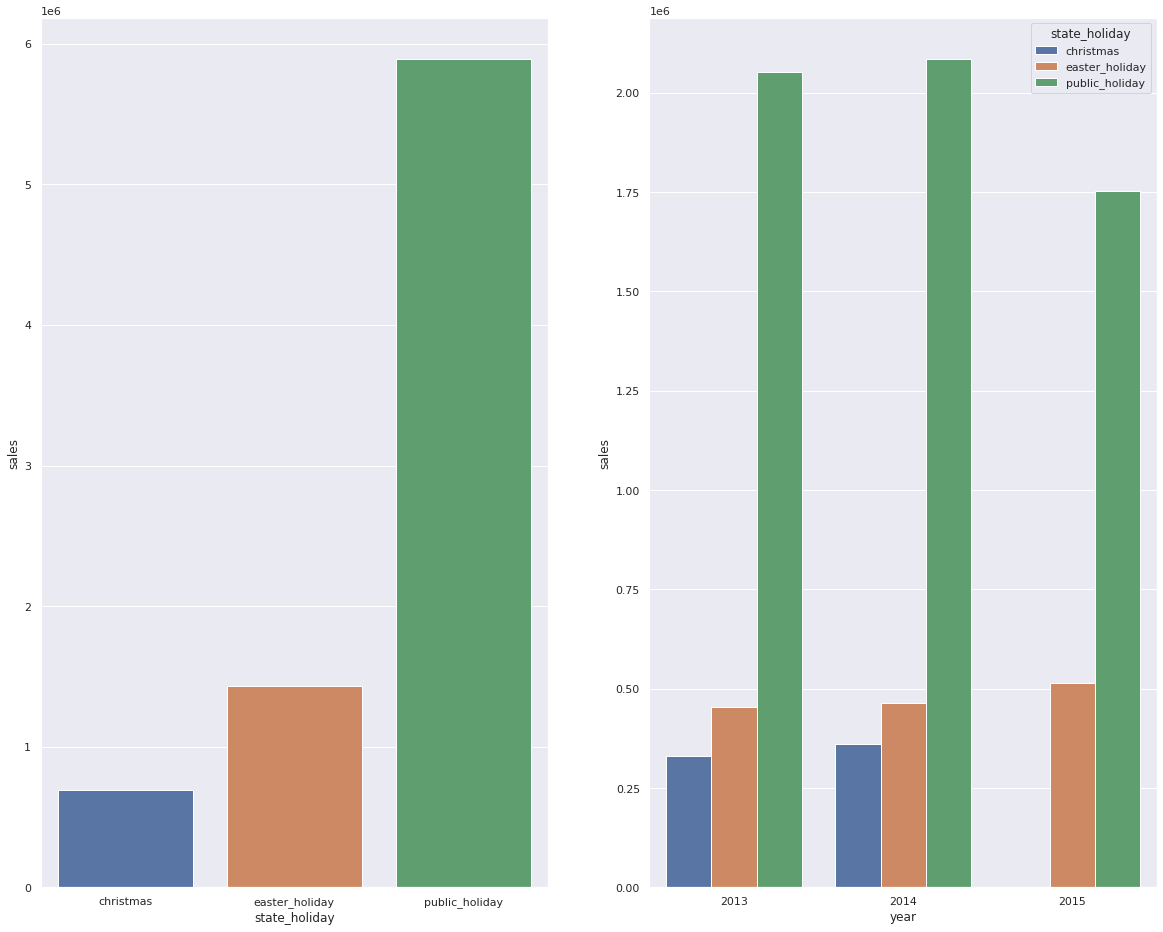

In [62]:
aux = df4[df4['state_holiday'] != 'regular_day'] #filtramos apenas os feriados pois os dias regulares são muito mais massantes

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index() #observamos que as vendas de natal são menores de forma geral e precisamos confirmar se é assim sempre
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index() #fizemos as vendas por feriado e por ano, confirmamos que o natal as vendas são poucas!
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 ); #não temos o segundo semestre de 2015 
                                                                    #hue determinar o formato que voce quer das suas barras no gŕafico 

### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo dos anos

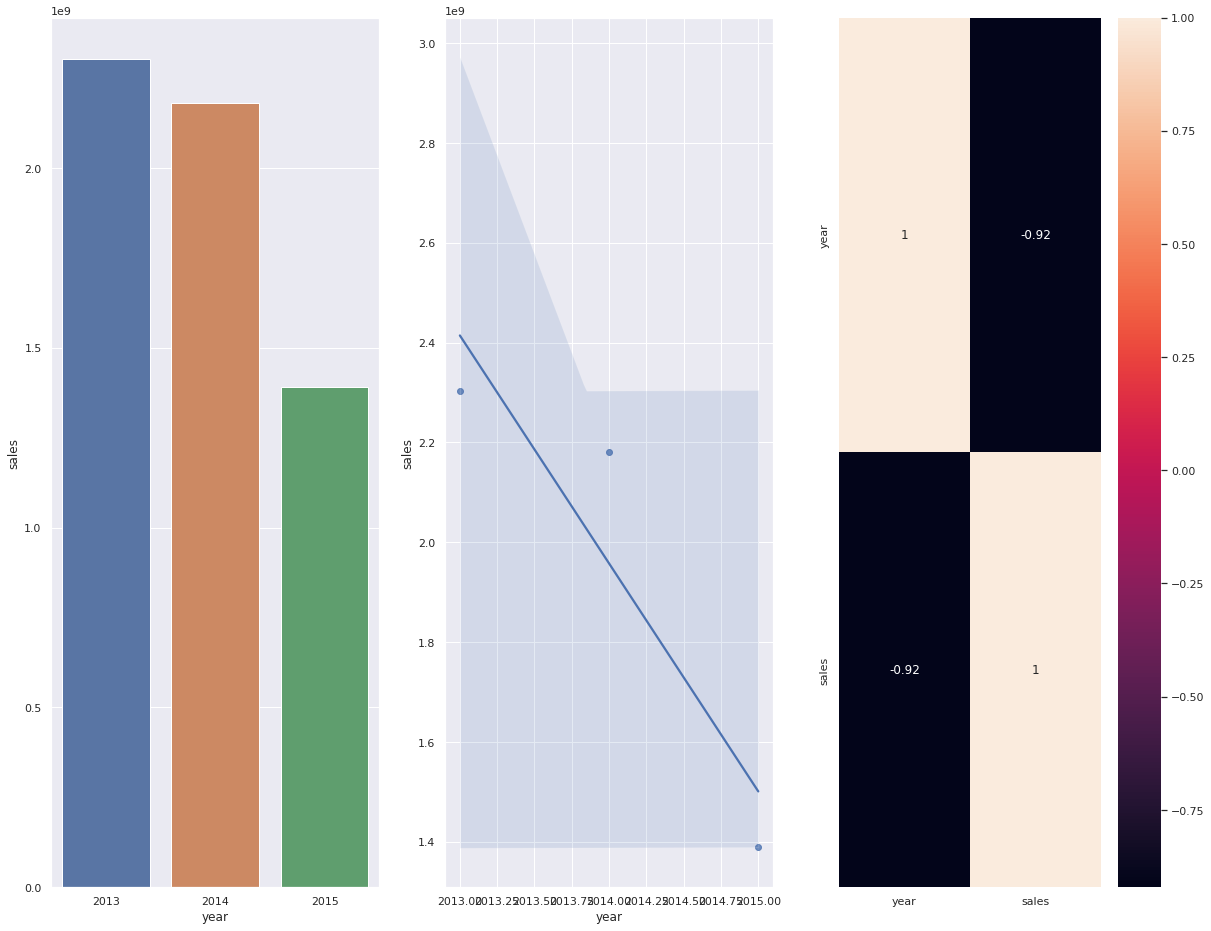

In [63]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index() #agrupamos por anos e fizemos a soma das vendas 

plt.subplot( 1, 3, 1 ) #grafico de barras, observamos que as vendas vem caindo 
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 ) #gráfico que nos retornar a tendência das vendas
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 ) #gráfico para descobrimos a força(correlação) da váriavel (Correlação forte pois o periodo de 2015 não está feixada) 
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano

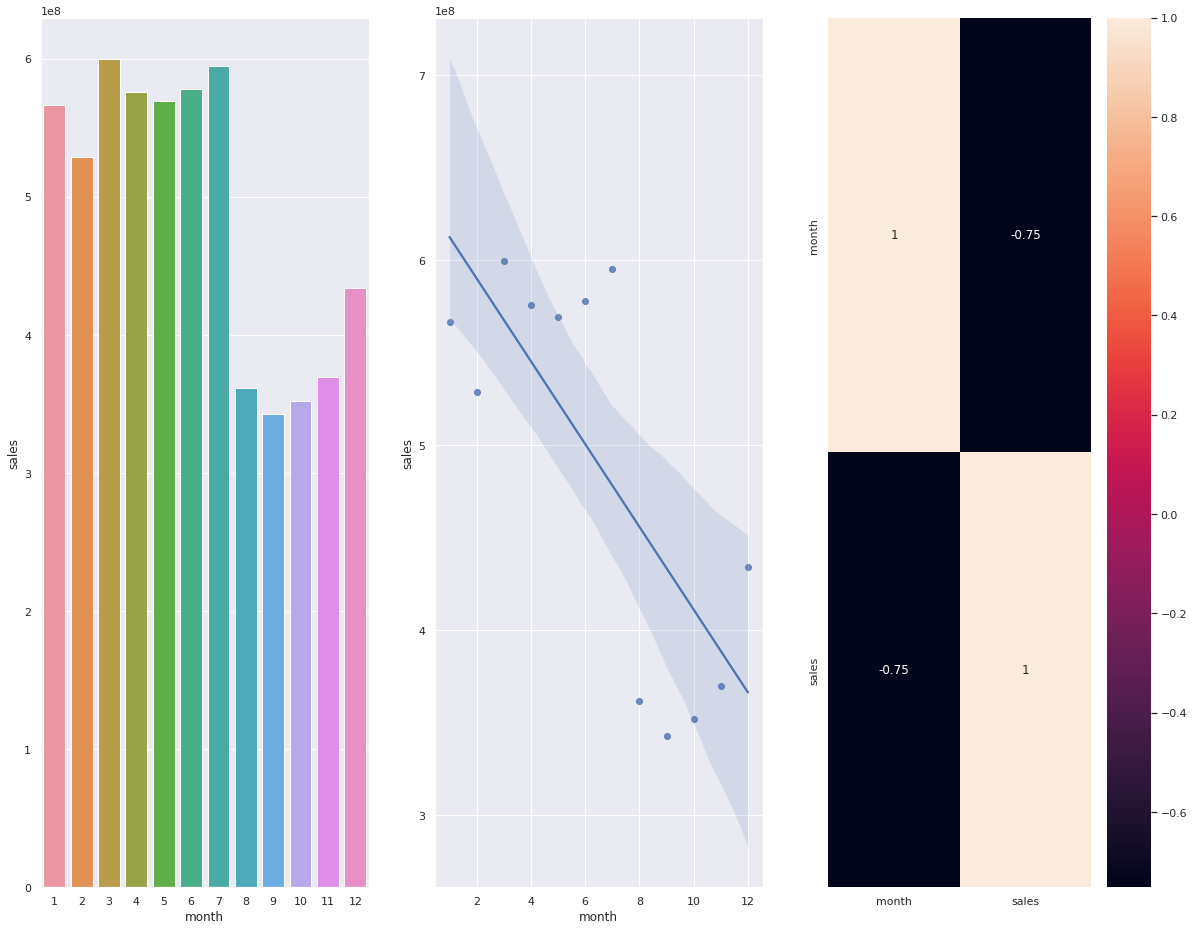

In [64]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index() #agrupamos a soma das vendas por mes

plt.subplot( 1, 3, 1 ) #grafico de barras, observamos que as vendas no segundo semestre caiem drasticamente e volta a vender um pouco mais em dezembro 
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 ) # gráfico que nos tras a tendencia das vendas 
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 ) #gráfico que retorna a carrelação dos meses com as vendas (correlação forte )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

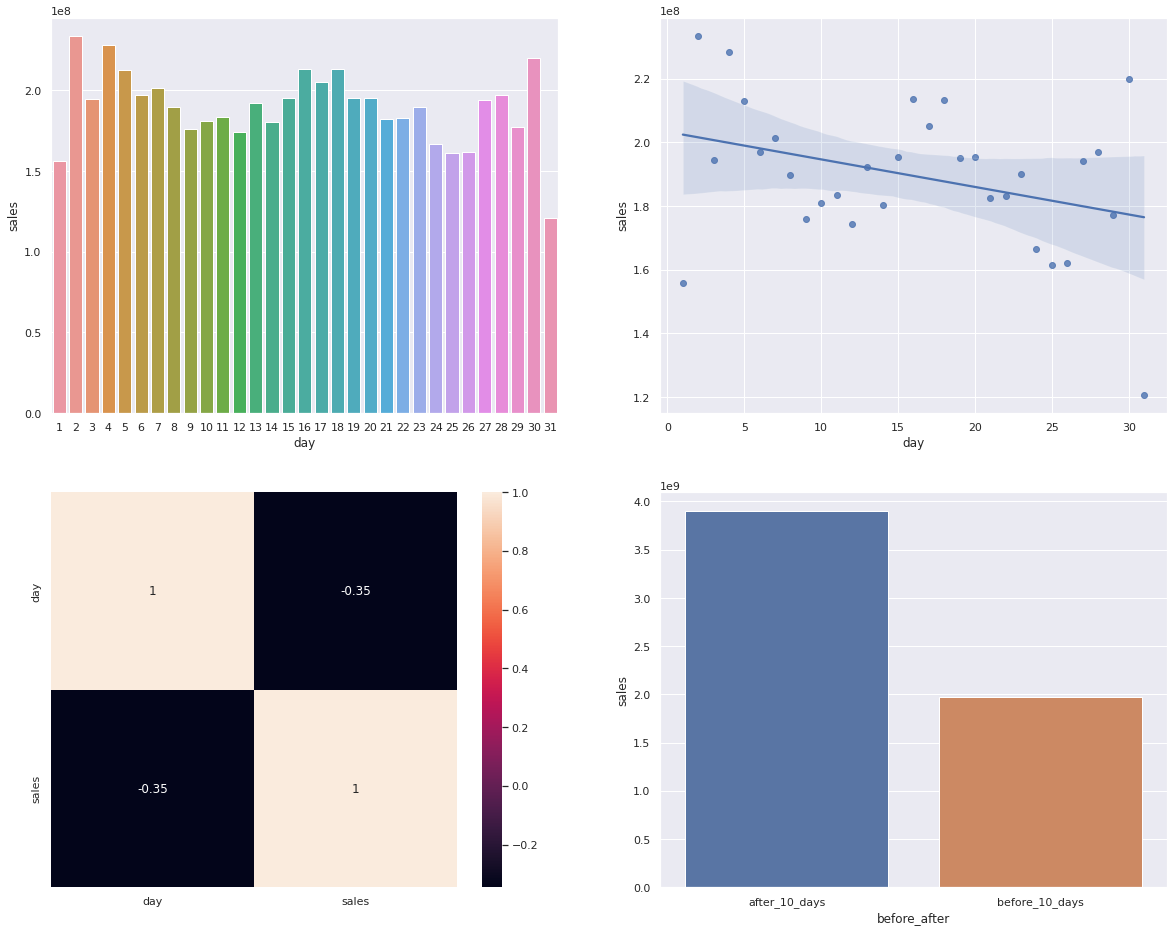

In [65]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index() #agrupamos a soma das vendas por dia 

plt.subplot( 2, 2, 1 ) #grafico de barra das vendas por dia, observamos que as lojas vendem mais deois do dia 
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 ) #grafico de tendencia das vendas
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 ) #correlação dos dias para a venda (correlação não tão forte)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' ) #segração dos dados em dias antes do dia 10 e dias depois do dia 10 
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 ) #grafico em barras de comparação entre as vendas antes e depois do dia 10
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos nos final de semana

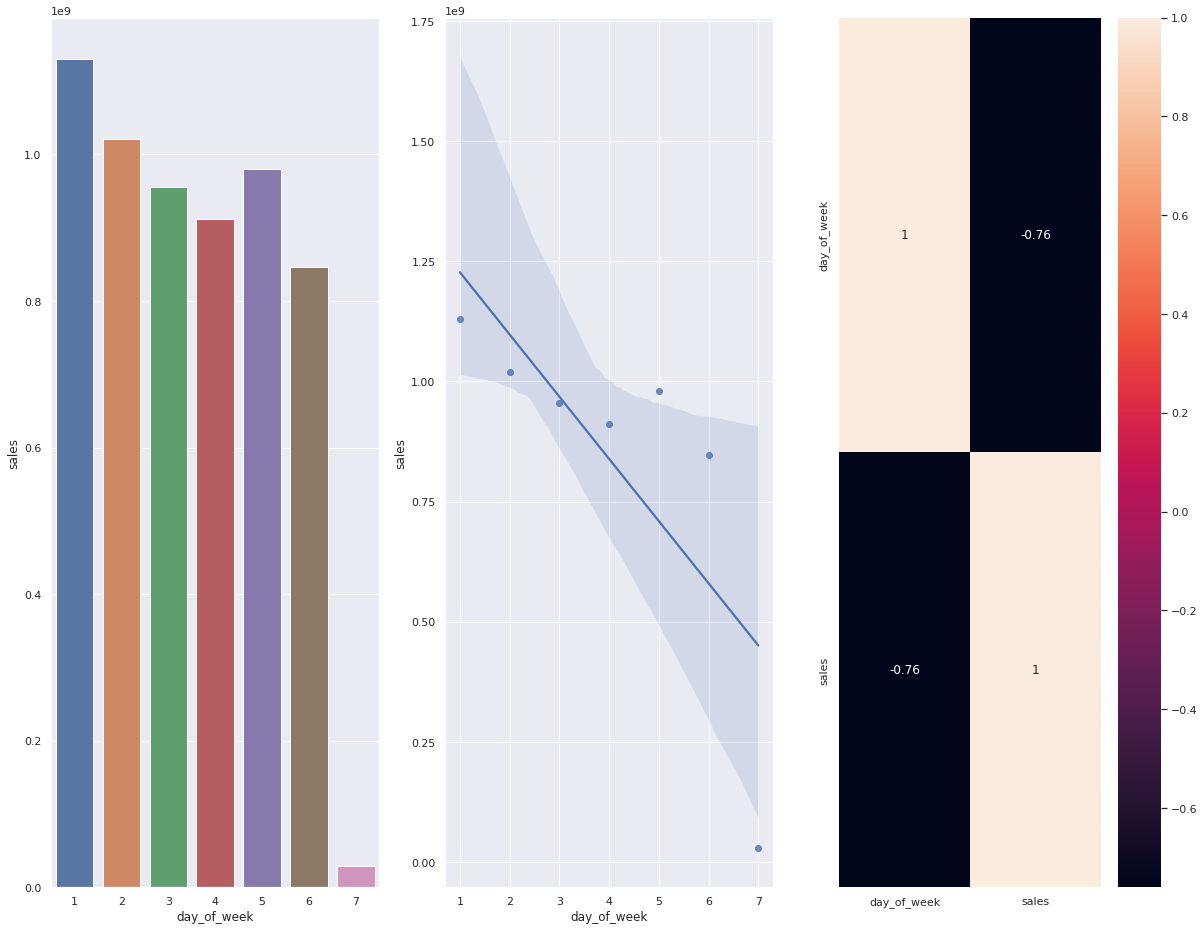

In [66]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index() #agrupamos as vendas por dias da semana

plt.subplot( 1, 3, 1 ) #grafico de barra das vendas por dia, observamos que realmente as vendas no sabado são menores e no domingo caem drasticamente
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 ) #grafico que retorna a tendencia
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 ) #grafico para sabermos a correlação dos dias da semana com as vendas 
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

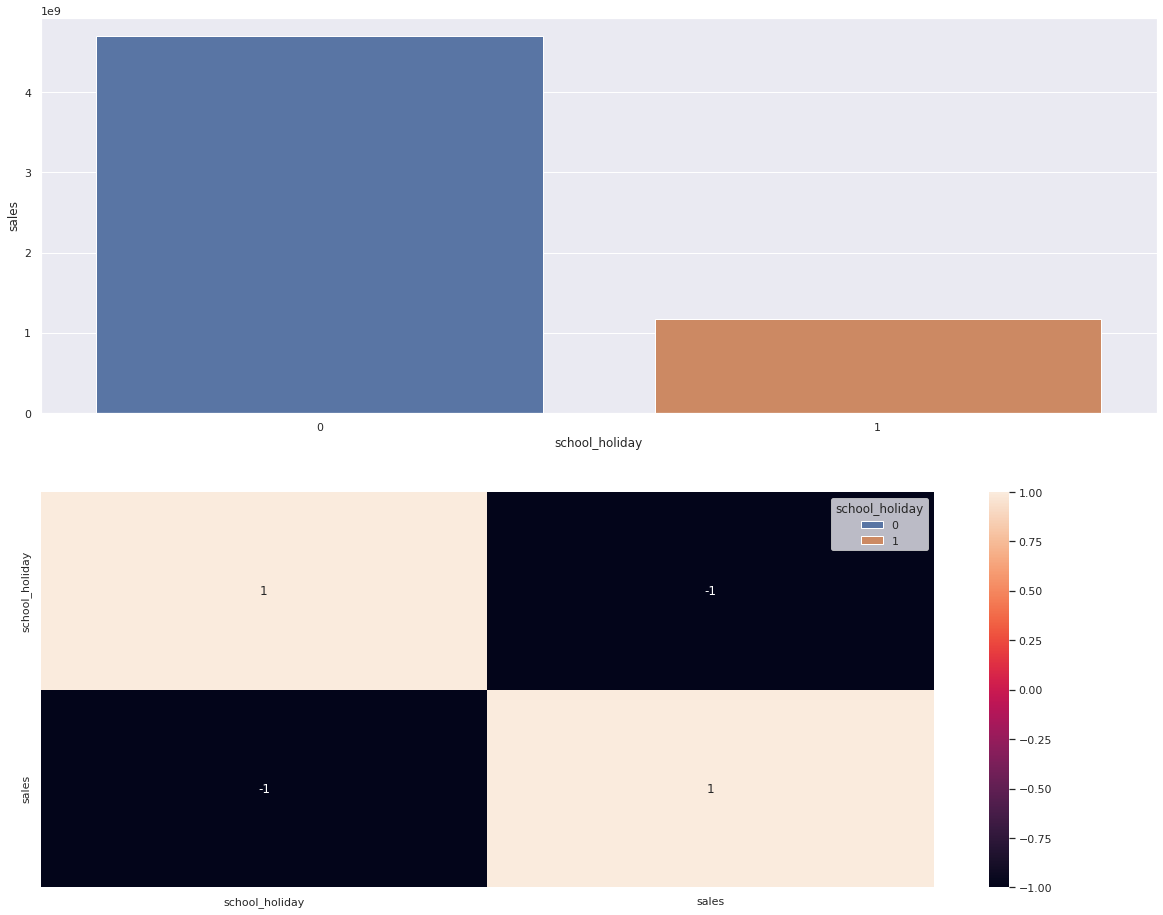

In [68]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index() #agrupamos as vendas por feriados escolares 

plt.subplot( 2, 1, 1 ) #grafico de barras pelos feriados escolares
sns.barplot( x='school_holiday', y='sales', data=aux1 );   

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index() #pegamos essa variação por mes para ver o comportamento mensal 

plt.subplot( 2, 1, 2 ) # grafico de barras das vendas em feriados escolares no decorrer dos meses 
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### 4.3 - Resumo das Hipoteses

In [71]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

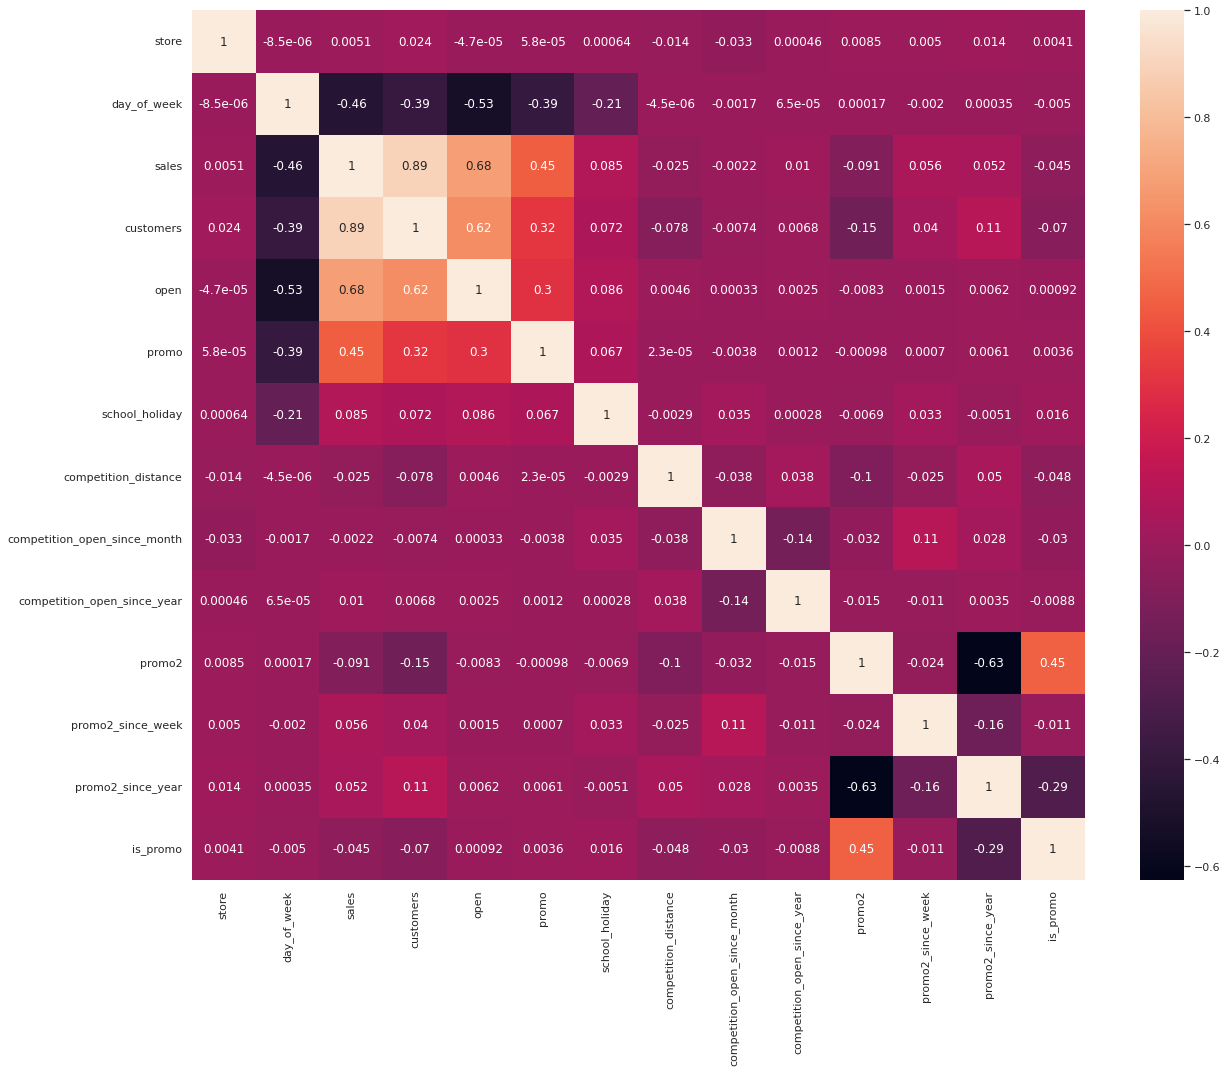

In [72]:
correlation = num_attributes.corr(method = 'pearson') #metodo pearson para ver as correlações entre as variaveis numericas
sns.heatmap (correlation, annot = True) #mais perto do branco (1 positivo) maior a correlação (proporcional)
                                        #mais perto do preto (1 negativo) menor a correlação (inversamente proporcional)
                                        #matriz simetrica, com o corte na diagonal, os lados sao espelhados
        
#pearson teste estatistico pra calcular a correlação entre duas variaveis numericas, não pode ser utilizado em caso de variaveis categoricas

### 4.3.1 Categorical Attributes

In [ ]:
#usamos o metodo de cramer v para calcular correlações entre variaveis categoricas, parecido com o de pearson porem para variaveis categoricas 

In [73]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
188313,0,a,a,"Jan,Apr,Jul,Oct",Feb
542302,0,a,a,0,Mar


In [76]:
#
a = df4.select_dtypes(include ='object')
a #3 colunas

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


In [106]:
v = np.sqrt((chi2/n)/(min(k-1,r-1))) # V valor a ser encontrado
                                     #chi2 chama de qui-quadrado obtido no teste de pearson
                                     #n é a soma total das observações
                                     #k numero de colunas do resultado das observações
                                     #r numero de linhas do resultado das observações
                                     
#chi2 ja tem metodo para calcular no python
chi2 = stats.chi2_contingency (cm)[0] #teste de pearson
                                      #stats é a biblioteca responsável para realizar o teste
                                      #cm tabela de contingẽncia
                                      #primeiro é o resultado do teste (só estamos interessados nesse resultado, por enquanto)
                                      #segundo é p valor
                                      #terceiro é o numero de graus de liberdade
                                      #quarto é a tabela de frequencia
                        
cm = pd.crosstab(a['state_holiday'], a['store_type']).values #o calculo da tabela de contigencia precisa ser uma matriz, senão retorna 4 numeros
                                                             #tabela de contingência, conta todas as correlações das variaveis categoricas das variaveis passadas (contando o numero de                                                                           linhas entre elas)
                                                             #no dataset temos 4 linhas que possuem store_type =4 e state_holiday = 'chrstmas'
                                   
n = cm.sum() #numero da soma do total das observações 
r, k = cm.shape #pegamos do shape o numero de linhas e colunas

In [81]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')] #teste para ver as 4 linhas que possuem as condiçoes mencionadas a cima 

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [111]:
v = np.sqrt((chi2/n)/(min(k-1,r-1)))
v #v de cramer vai de 0 a 1 (sem numeros negativos), quanto mais perto do 0 menor a correlação e quanto mais perto do 1 maior a correlação

0.07106457093267678

In [114]:
#USADO NA AREA DE HELP FUNCTIONS 

#apos aprender como é calculado, faremos uma função fazer isso entre todos as variaveis
#def cramer_v (x,y):
#    cm = pd.crosstab(x,y).values
#    n = cm.sum()
    
#    r , k = cm.shape 
    
#    chi2 = stats.chi2_contingency (cm)[0]
#    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) #corr = as variaveis com o corr (corrigidas), precisam dessa correção pq o v de cramer tem um alto vies em relação ao extimador(ele sempre tende a                                                  extimar um numero muito maior do que ele realmente é na associação)
    
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
    
#    v = np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    
#    return v
#agora basta passar as colunas como argumento da função onde será calculada o grau de correlação 

#cramer_v(a['state_holiday'], a['store_type']) # o resultado manteve o valor, mas manteremos a correção para caso em que o resultado altera 

0.07106469715258833

In [118]:
a1 = cramer_v(a['state_holiday'], a['state_holiday']) #criação da matriz para vermos todas as correlações 
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame ({'state_holiday': [a1,a2,a3],
                   'store_type': [a4,a5,a6],
                   'assortment': [a7,a8,a9]})
d = d.set_index (d.columns) #todas as colunas como indices da matriz, para os indices e as colunas terem os mesmos nomes 
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

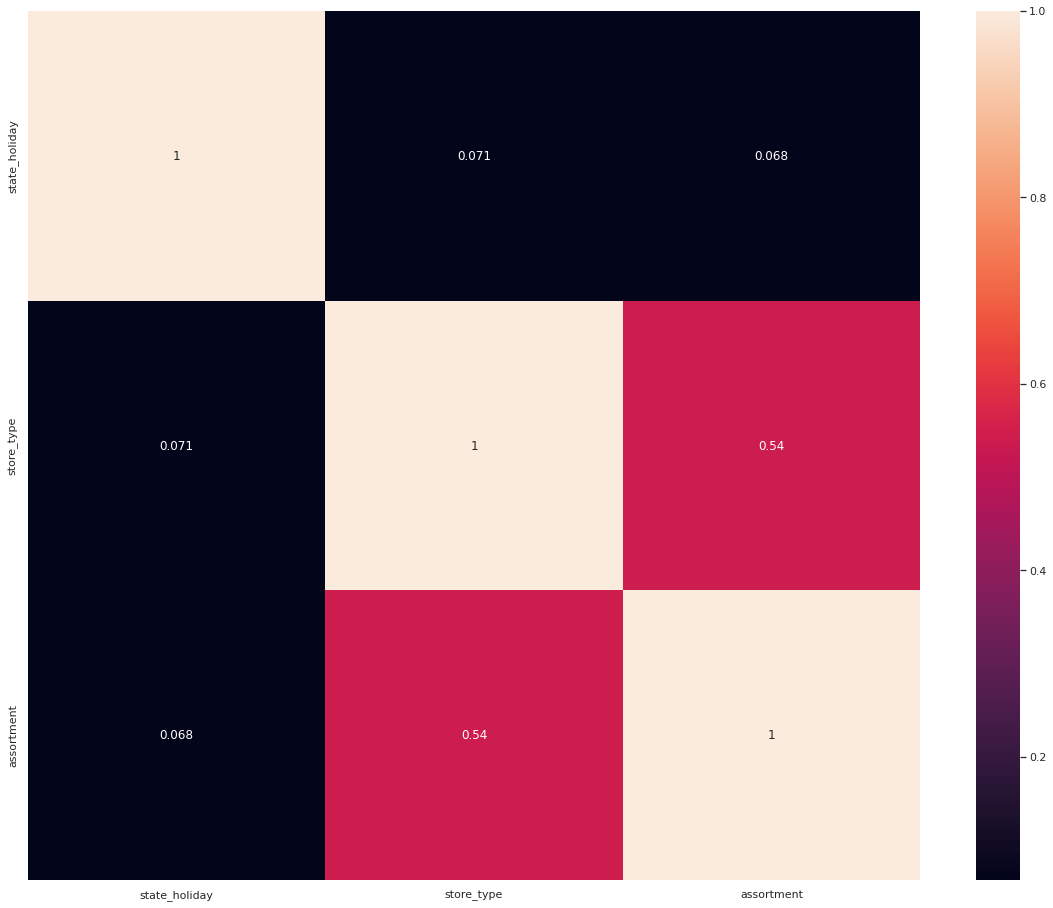

In [119]:
sns.heatmap(d, annot= True) #mapa que tras as correlações das variaveis, neste caso categoricas 

<AxesSubplot:>

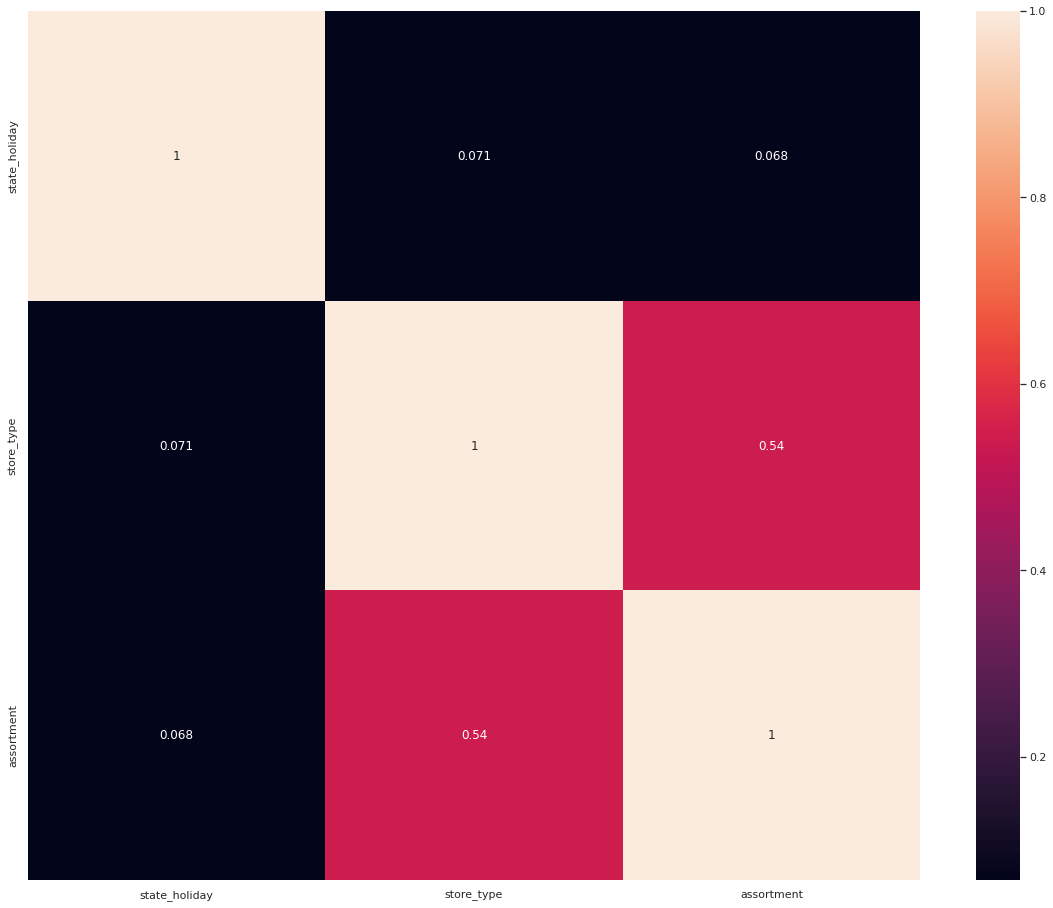

In [120]:
#CALCULAR O MAPA DE CORRELAÇÕES DE FORMA DIRETA 

# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0